In [ ]:
! pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 2.8 MB/s eta 0:00:00


### Import libraries

In [ ]:
import os
import torch
import numpy as np
from torcheval.metrics.functional import multiclass_accuracy, multiclass_auroc, multiclass_recall
import torch.nn as nn
from torch.optim import Adam, AdamW
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_path = "/content/drive/MyDrive/Deep_learning_course/Text_processing/"
project_path = os.path.join(root_path, "Classify_Reviews")
nltk_folder_path = "/content/lmtools/"
data_path = "/content/data/"
file_path = os.path.join(data_path, "reviews_test.csv")

In [ ]:
external_lmtool_path = os.path.join(root_path, "nltk_data.zip")
local_lmtool_path = nltk_folder_path
!unzip -q $external_lmtool_path -d $local_lmtool_path

In [ ]:
import nltk
nltk_path = os.path.join(nltk_folder_path, "nltk_data")
nltk.data.path.insert(0, nltk_path)

In [ ]:
lib_path = os.path.join(project_path, "src")
import sys
sys.path.append(lib_path)
# from embedding_dictionary import EmbeddingDictionary
from embedding_sequence import SequenceFromText
from data_loader import dataloader_reviews_test
from sequencial_model import SequencialModel

### Load dictionary

In [ ]:
external_data_path = os.path.join(project_path, "data/")
local_data_path = data_path
!cp -r $external_data_path -d $local_data_path

In [ ]:
with open(os.path.join(external_data_path, "w2v_dict.pkl"), "rb") as f:
  w2v_dict = pickle.load(f)

### Create sequences

In [ ]:
sequence_length = 52

In [ ]:
sequence_maker = SequenceFromText(
    text_path=file_path,
    word_dictionary=w2v_dict,
    series_length=sequence_length
)

In [ ]:
sequences = sequence_maker.create_sequence()

### Load data

In [ ]:
# data parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(w2v_dict)
batch_size = 5_000
num_workers = 8
# model parameters
model_load = "sequential_multiple_layers4_1.pkl"
model_load = os.path.join(project_path, "models/", model_load)
metrics = [multiclass_accuracy]
EPOCHS = 500

In [ ]:
data_test = dataloader_reviews_test(
    X=sequences[0],
    Y=sequences[1],
    vocab_size=vocab_size,
    batch_size=batch_size,
    num_workers=num_workers,
    device=device
)

### Load pretrained

In [ ]:
state = torch.load(model_load, map_location=torch.device('cpu'))

In [ ]:
model = SequencialModel(
    embedding_dim=300,
    vocab_size=vocab_size,
    hidden_size=300,
    num_classes=5,
    num_layers=4,
    padding_idx=w2v_dict["unk"]
)
model.load_state_dict(state["model"])
model = model.to(device)

### Test model

In [ ]:
def test_model(model, data_test):
  model.eval()
  with torch.no_grad():
    for i, batch in tqdm(enumerate(data_test), total=len(data_test)):
      batch_x = batch["X"].to(device)
      batch_y = batch["Y"].to(device)

      y_pred = model(batch_x)
      accuracy = multiclass_accuracy(y_pred, batch_y).item()
      recall = multiclass_accuracy(y_pred, batch_y, num_classes=5, average=None)
      auroc = multiclass_auroc(y_pred, batch_y, num_classes=5).item()

    print(f"accuracy: {accuracy}")
    print(f"auroc: {auroc}")
    print(f"recall: {recall}")

  return accuracy, recall, auroc

In [ ]:
acc, rec, aurc = test_model(model, data_test)

  0%|          | 0/1 [00:00<?, ?it/s]

accuracy: 0.6038069725036621
auroc: 0.7482097744941711
recall: tensor([0.0000, 0.0000, 0.6312, 0.1426, 0.8942])


In [ ]:
from collections import Counter
Counter(sequences[1])

Counter({3: 491, 4: 1248, 1: 157, 2: 282, 0: 81})

### Training stats

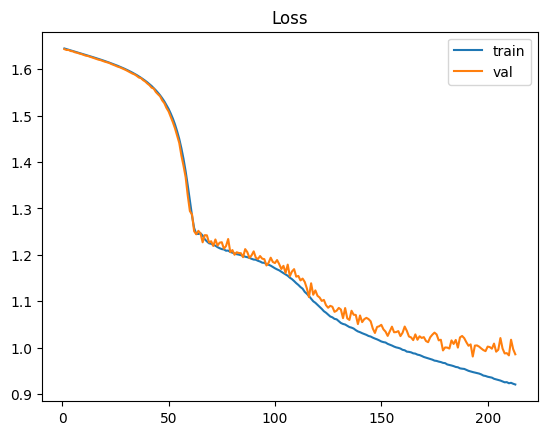

In [ ]:
plt.plot(state["loss_history"], label="train")
plt.plot(state["val_loss_history"], label="val")
plt.title("Loss")
plt.legend()

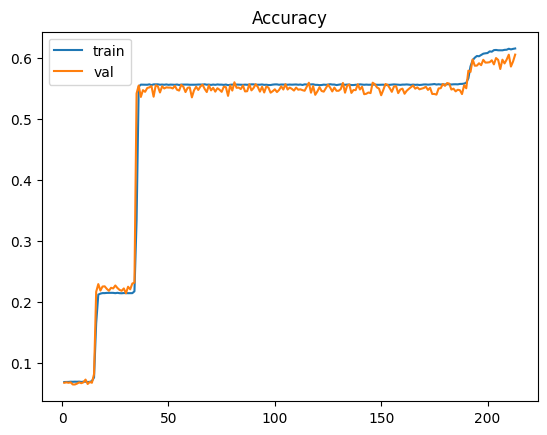

In [ ]:
plt.plot(state["metric_history"]["multiclass_accuracy"], label="train")
plt.plot(state["val_metric_history"]["multiclass_accuracy"], label="val")
plt.title("Accuracy")
plt.legend()

In [40]:
state["val_metric_history"]["multiclass_accuracy"][-1]

0.6053138673305511